# Imports

In [2]:
import os
from tqdm import tqdm
import pickle as pkl
import itertools as iter
from matplotlib import pyplot as plt
import sys; sys.path.append('..')
from experiments.functions_Filippo import *
import warnings
import itertools
from IPython.display import Markdown
import io
import pandas as pd
import seaborn as sns
import time
import wfdb
from scipy import signal

from ecgdetectors import Detectors

import torch
torch.manual_seed(0);
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader, random_split


In [3]:
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))


from dataset import dataset_dir
from cs import generate_sensing_matrix
from cs.utils import compute_rsnr
from models.unet import UNet

In [4]:
gpus = "3"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=gpus

os.environ['SCIPY_USE_PROPACK'] = "True"

# limit number of parallel threads numpy spawns
workers_mp = 1 # number of workers for mp.pool
threads_np = "1" # number of threads np generates for every worker

os.environ["OMP_NUM_THREADS"] = threads_np
os.environ["OPENBLAS_NUM_THREADS"] = threads_np
os.environ["MKL_NUM_THREADS"] = threads_np
os.environ["VECLIB_MAXIMUM_THREADS"] = threads_np
os.environ["NUMEXPR_NUM_THREADS"] = threads_np
import numpy as np

In [5]:
def cell_vars(pop=None, verbose=False):
    _bundle = get_cell_vars_as_dict(ipy=get_ipython(), out=io.StringIO(), glob=globals(), offset=0)
    
    if pop is not None and pop in _bundle.keys():
        _bundle.pop(pop)

    for k, v in _bundle.items():
        _b = _bundle.copy()
        _b.pop(k)
        if v==_b or v=={}:
            _bundle.pop(k)
            break;
    
    if verbose: [print(k) for k in _bundle]
    return _bundle

In [6]:
bundle_param = {}

### Dataset parameters

In [19]:
# N = 10_000
N = 2_000_000
# N = 100_000
n = 128
n_iddb = 256
n_mit_bih = 256
# seed_ecg = 42
seed_ecg = 11
fs = 256 # sampling freq
hr0 = 60 # heart rate low
hr1 = 100 # hear rate high
isnr = 1000 # dB (intrinsic snr)

_b = cell_vars(pop='_b')

In [8]:
bundle_param = bundle_param | _b

### A parameters

In [9]:
# m = [48]
# m = [16, 32, 48]
m = 32
# N_try_A = [1_000]
N_try_A = 100
mode_A = 'rakeness'
seed_A = 0
index_A = 0
orth = True
str_corr = '96af96a7ddfcb2f6059092c250e18f2a'
loc = 0.25 # localization for rakeness

_b = cell_vars(pop='_b')

In [10]:
bundle_param = bundle_param | _b

### Unet parameters

In [11]:
in_channels = 1
out_channels = 1
# expanded_channels = [64, 32, 16]
expanded_channels = 32
# step_number = [4, 3, 2]
step_number = 3
# kernel_size = [3, 5, 7]
kernel_size = 3
residual = True
use_batch_norm = False
simple_pool = False
# seed_torch = 0
# seed_torch = [0, 1, 2, 3]
seed_torch = [0, 1, 2, 3]
# seed_torch = 0
# seed_torch = [0, 1, 2, 3]
# white_noise_var = 0.001
white_noise_var = 0
white_noise_isnr = [20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0]
# white_noise_isnr = [25.0, 35.5, 45.0]
str_x_as_input = True
str_A_init = True
str_A_freeze = True

_b = cell_vars(pop='_b')

In [12]:
bundle_param = bundle_param | _b

### Dataset for A generation

In [13]:
_ecg_N_forA = 10_000
_n_forA = 128
_fs_forA = 256
_hr0_forA = 60
_hr1_forA = 100
_isnr_forA = 35
_seed_forA = 0

_b = cell_vars(pop='_b')

In [14]:
bundle_param_A_dataset = _b.copy()
bundle_param = bundle_param_A_dataset | bundle_param
for k, v in bundle_param.items():
    if type(v) is list and len(v)==1:
        bundle_param[k] = v[0];

In [15]:
bundle_param

{'_ecg_N_forA': 10000,
 '_n_forA': 128,
 '_fs_forA': 256,
 '_hr0_forA': 60,
 '_hr1_forA': 100,
 '_isnr_forA': 35,
 '_seed_forA': 0,
 'N': 2000000,
 'n': 128,
 'seed_ecg': 11,
 'fs': 256,
 'hr0': 60,
 'hr1': 100,
 'isnr': 1000,
 'm': 32,
 'N_try_A': 100,
 'mode_A': 'rakeness',
 'seed_A': 0,
 'index_A': 0,
 'orth': True,
 'str_corr': '96af96a7ddfcb2f6059092c250e18f2a',
 'loc': 0.25,
 'in_channels': 1,
 'out_channels': 1,
 'expanded_channels': 32,
 'step_number': 3,
 'kernel_size': 3,
 'residual': True,
 'use_batch_norm': False,
 'simple_pool': False,
 'seed_torch': [0, 1, 2, 3],
 'white_noise_var': 0,
 'white_noise_isnr': [20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0],
 'str_x_as_input': True,
 'str_A_init': True,
 'str_A_freeze': True}

#### Select GPU

In [16]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:0 device


### Extract ECG (dataset)

#### SYNTH

In [17]:
path_ecg = from_bundle_to_ecg_path(bundle_param)

with open(path_ecg, 'rb') as f:
    ecg_synth = pkl.load(f)[:, np.newaxis]

#### REAL ECG IDDB

In [ ]:


db_dir = 'ecgiddb'
dl_dir = 'miao'
# str_type_signal = 'ECG I filtered'
str_type_signal = 'ECG I'

if not(os.path.exists(dl_dir)):
    wfdb.io.dl_database(db_dir, dl_dir, records='all', annotators=None, keep_subdirs=True, overwrite=False)

ecg_iddb = None
ecg_iddb_filt = None

for _p in os.listdir(dl_dir):
    _path = os.path.join(dl_dir, _p)
    
    for _p2 in os.listdir(_path):

        if _p2[-4:] == '.dat':

            _p2 = _p2.replace('.dat', '')

            _path2 = os.path.join(_path, _p2)

            record = wfdb.io.rdrecord(_path2)
            
            _fs = record.fs

            record, record_filt = record.to_dataframe()['ECG I'].to_numpy(), record.to_dataframe()['ECG I filtered'].to_numpy()
            
            record = signal.resample_poly(record, fs, _fs)
            record_filt = signal.resample_poly(record_filt, fs, _fs)

            record = split_with_overlap(record, segment_length=n_iddb, overlap=n_iddb//5)
            record_filt = split_with_overlap(record_filt, segment_length=n_iddb, overlap=n_iddb//5)

            if ecg_iddb is None:
                ecg_iddb = record
                ecg_iddb_filt = record_filt

            else:
                ecg_iddb = np.append(ecg_iddb, record, axis=-2)
                ecg_iddb_filt = np.append(ecg_iddb_filt, record_filt, axis=-2)


            
ecg_iddb = ecg_iddb[1:, np.newaxis]
ecg_iddb_filt = ecg_iddb_filt[1:, np.newaxis]

In [21]:
np.shape(ecg_iddb)
np.shape(ecg_iddb_filt)

(15189, 1, 128)

#### REAL ECG MIT-BIH-Arrhythmia

In [ ]:
db_dir = 'mitdb'
dl_dir = 'MIT-BIH-Arrhythmia'


if not(os.path.exists(dl_dir)):
    wfdb.io.dl_database(db_dir, dl_dir, records='all', annotators='all', keep_subdirs=True, overwrite=False)

overlap = n_mit_bih//5

ecg_mit_bih = None
ecg_mit_bih_r_peaks = None


listdir = os.listdir(dl_dir)
listdir = np.unique([s.split('.')[0] for s in listdir])

for _p2 in tqdm(listdir):
    
    ### .dat & .atr

    _path2 = os.path.join(dl_dir, _p2)

    record = wfdb.io.rdrecord(_path2)
    ann = wfdb.io.rdann(_path2, extension='atr')
    
    _fs = record.fs
    
    record = record.p_signal[:, 0]
    record = signal.resample_poly(record, fs, _fs)
    r_peaks_ind = np.array(ann.sample)

    r_peaks_ind = np.floor(r_peaks_ind * fs / _fs).astype(int)
    
    r_peaks = np.zeros(np.shape(record))
    
    r_peaks[r_peaks_ind] = 1

    record = split_with_overlap(record, segment_length=n_mit_bih, overlap=overlap)
    r_peaks = split_with_overlap(r_peaks, segment_length=n_mit_bih, overlap=overlap)

    if ecg_mit_bih is None:
        ecg_mit_bih = record
        ecg_mit_bih_r_peaks = r_peaks

    else:
        ecg_mit_bih = np.append(ecg_mit_bih, record, axis=-2)
        ecg_mit_bih_r_peaks = np.append(ecg_mit_bih_r_peaks, r_peaks, axis=-2)
        
ecg_mit_bih = ecg_mit_bih[:, np.newaxis]

100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


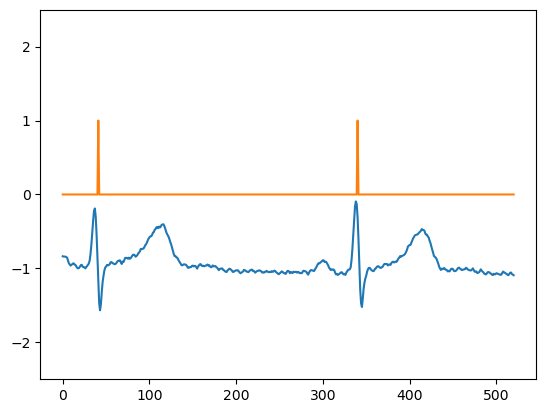

In [30]:
_ind = np.random.randint(0, len(ecg_mit_bih_r_peaks))
plt.plot(ecg_mit_bih[_ind][0])
plt.ylim(-2.5, 2.5)
plt.plot(ecg_mit_bih_r_peaks[_ind],)


[94, 370]
[74, 360]
[362]
[88, 372]
[83, 367]


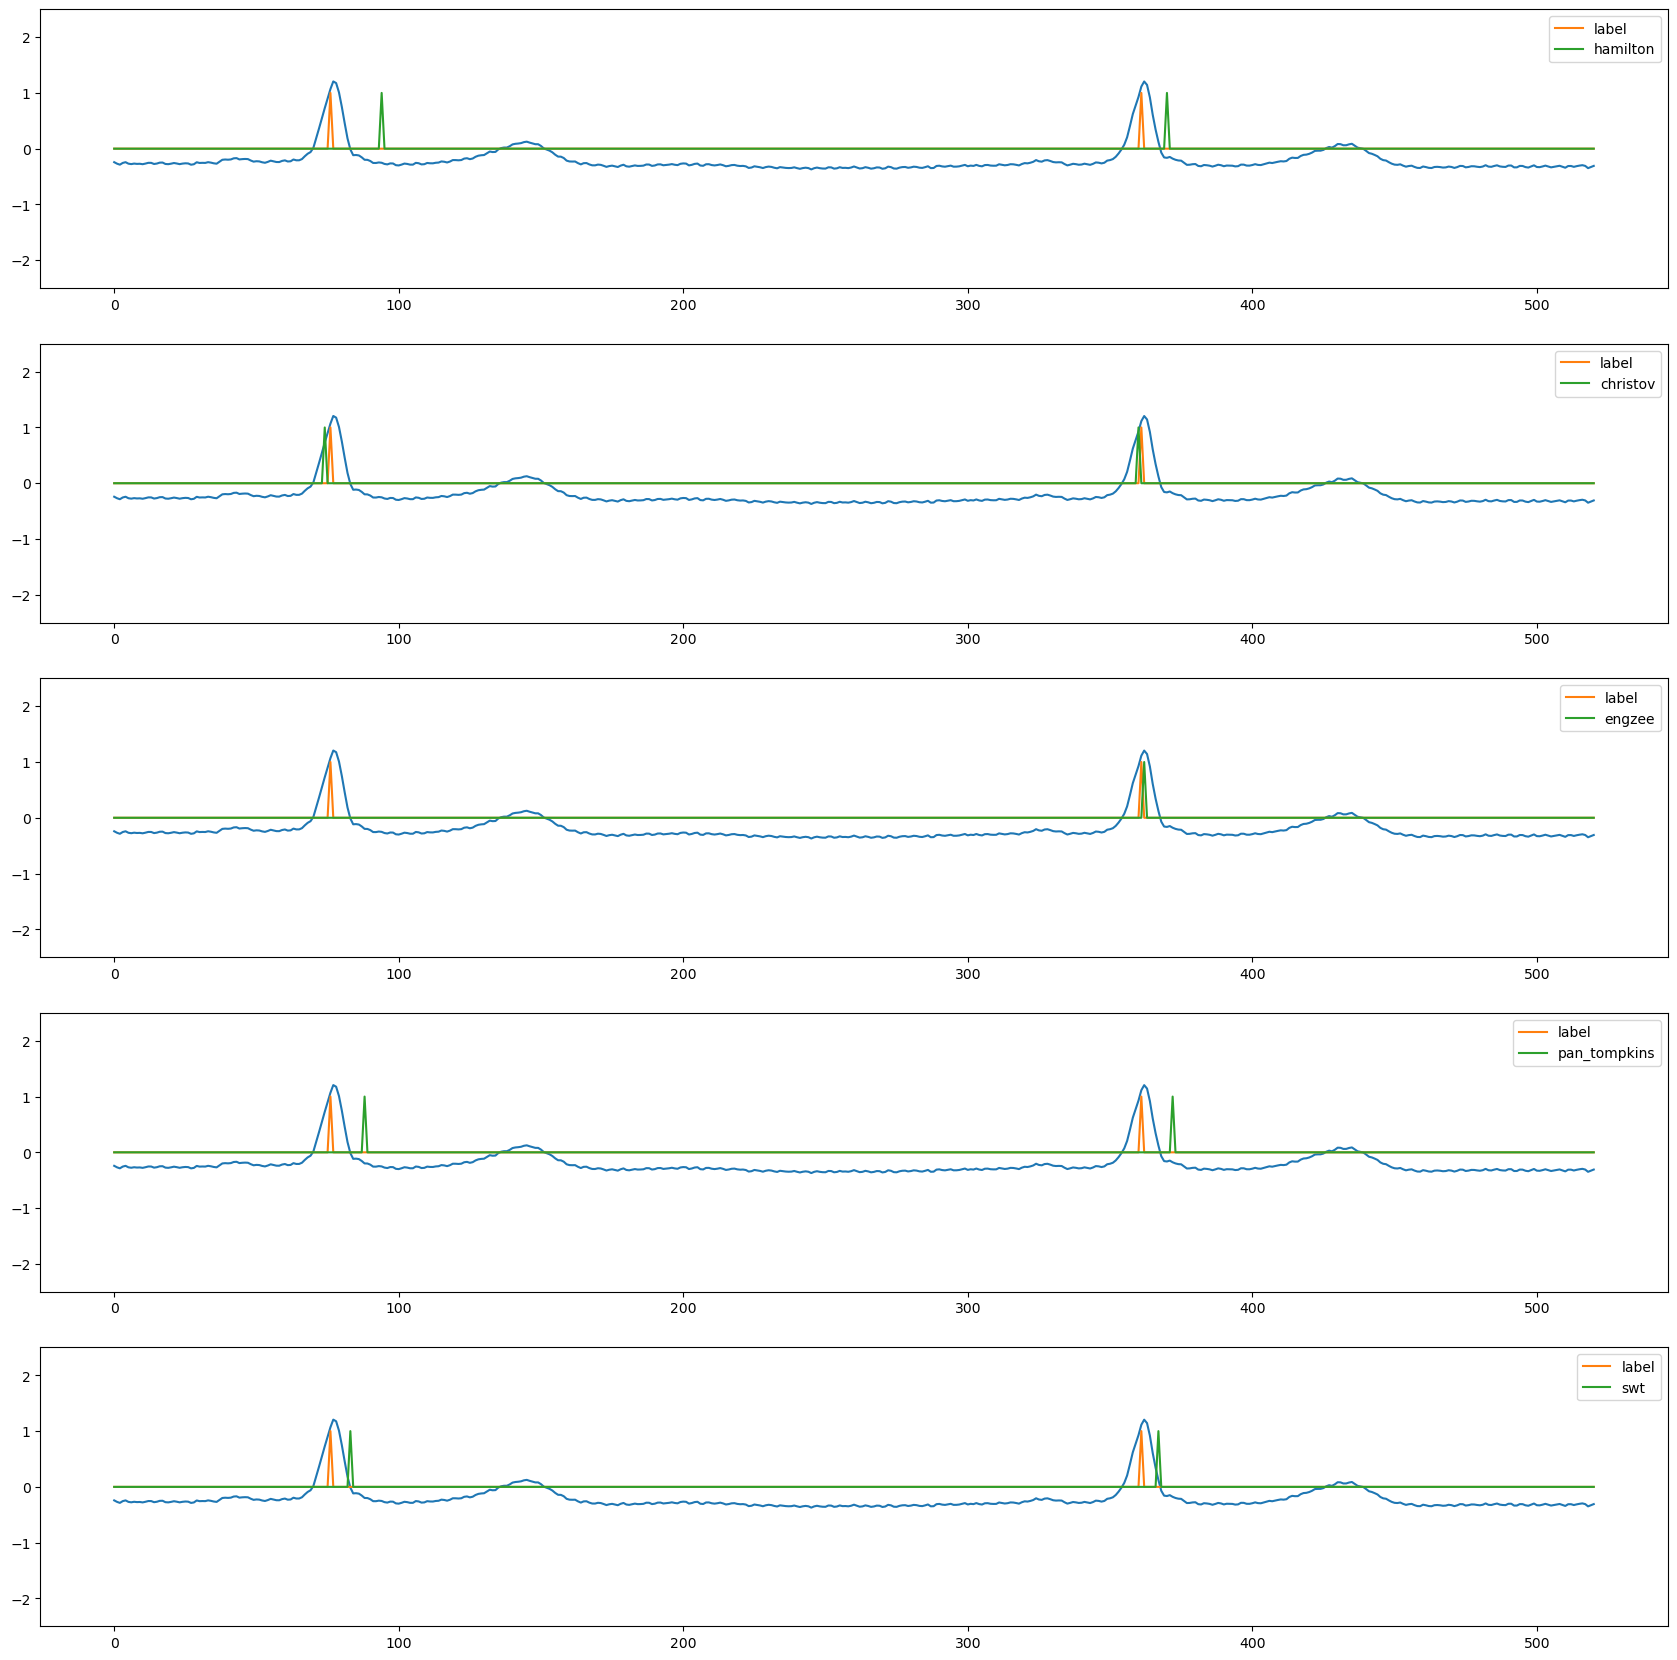

In [44]:
fig, axs = plt.subplots(5, 1, figsize=(21, 21))
_ind = np.random.randint(0, len(ecg_mit_bih_r_peaks))
_ecg = ecg_mit_bih[_ind][0]
for ax in axs:
    ax.plot(_ecg)
    ax.set(ylim=(-2.5, 2.5))
    ax.plot(ecg_mit_bih_r_peaks[_ind], label='label')

detectors = Detectors(fs)
r_peaks = detectors.hamilton_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
axs[0].plot(_z, label='hamilton')

r_peaks = detectors.christov_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
axs[1].plot(_z, label='christov')

r_peaks = detectors.engzee_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
axs[2].plot(_z, label='engzee')

r_peaks = detectors.pan_tompkins_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
axs[3].plot(_z, label='pan_tompkins')

r_peaks = detectors.swt_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
axs[4].plot(_z, label='swt')

for ax in axs:
    ax.legend()

In [ ]:

r_peaks = detectors.wqrs_detector(unfiltered_ecg)
r_peaks = detectors.two_average_detector(unfiltered_ecg)

In [ ]:
ecg_mit_bih.shape

(215376, 1, 128)